In [188]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
import re

%matplotlib inline
os.chdir('/data/arpit.goel/32_RecruitRestarauntPrediction/')

df_air_reserve=pd.read_csv('01.RawData/air_reserve.csv',parse_dates=['visit_datetime','reserve_datetime'])
df_air_store_info=pd.read_csv('01.RawData/air_store_info.csv')
df_air_visit_data=pd.read_csv('01.RawData/air_visit_data.csv',parse_dates=['visit_date'])
df_date_info=pd.read_csv('01.RawData/date_info.csv',parse_dates=['calendar_date'])
df_hpg_reserve=pd.read_csv('01.RawData/hpg_reserve.csv',parse_dates=['visit_datetime','reserve_datetime'])
df_hpg_store_info=pd.read_csv('01.RawData/hpg_store_info.csv')
df_store_id_relation=pd.read_csv('01.RawData/store_id_relation.csv')
df_sample_submission=pd.read_csv('01.RawData/sample_submission.csv')
df_store_master=pd.read_csv('02.CleanData/01.StoreRegion.csv')

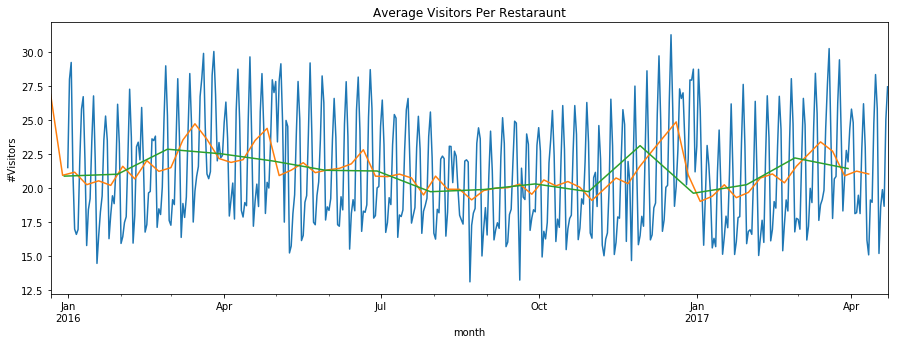

In [64]:
daily_visitors=df_air_visit_data.groupby(['air_store_id','visit_date'])['visitors'].sum().reset_index()
daily_visitors=pd.merge(daily_visitors,df_store_master,left_on=['air_store_id'],right_on=['store_id'],how='left')
daily_visitors['week']=daily_visitors['visit_date'].map(lambda x: x-timedelta(days=datetime.weekday(x)))
daily_visitors['weekday']=daily_visitors['visit_date'].map(lambda x: datetime.weekday(x))
daily_visitors['month']=daily_visitors['visit_date'].map(lambda x: x-timedelta(days=x.day+1))
plt.figure(figsize=(15,5))
plt.title('Average Visitors Per Restaraunt')
plt.xlabel('Date')
plt.ylabel('#Visitors')
daily_visitors.groupby(['visit_date'])['visitors'].mean().plot(label='Day')
daily_visitors.groupby(['week'])['visitors'].mean().plot()
daily_visitors.groupby(['month'])['visitors'].mean().plot()


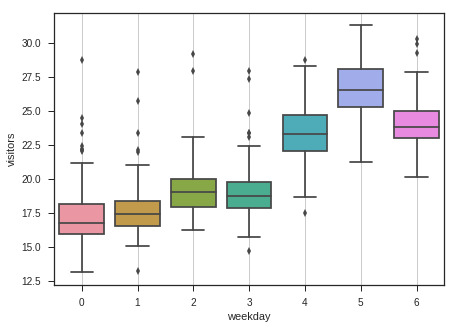

In [83]:
a=daily_visitors.groupby(['week','weekday'])['visitors'].mean().reset_index()
sns.set(style="ticks")
f,ax=plt.subplots(figsize=(7,5))
sns.boxplot(x=a['weekday'], y=a['visitors'])
ax.xaxis.grid(True)


In [2]:
daily_visitors=df_air_visit_data.groupby(['air_store_id','visit_date'])['visitors'].sum().reset_index()
daily_visitors['week_start']=daily_visitors['visit_date'].map(lambda x: x-timedelta(days=(datetime.weekday(x)+1)%7))
daily_visitors['visitors']=np.log(1+daily_visitors['visitors'])
weekly_visitors=daily_visitors.groupby(['air_store_id','week_start'])['visitors'].mean().reset_index()


In [16]:
weekly_visitors.head()
a=weekly_visitors[weekly_visitors.loc[:,'air_store_id']=='air_00a91d42b08b08d9']
modelling_dataset=[]
#if 1==1:
for i,(index,a) in enumerate(weekly_visitors.groupby(['air_store_id'])):
    visitors=pd.Series(a.loc[:,'visitors'].tolist(),index=a.loc[:,'week_start'].tolist())
    for week in range(8):
        a.loc[:,'tgt_visitors_%d'%week]=a.loc[:,'week_start'].map(lambda x: x+timedelta(days=7*week+7)).map(visitors)
    a.loc[:,'visitors_0']=a.loc[:,'visitors'].rolling(window=1).mean()
    for week in range(11):
        a.loc[:,'visitors_%d'%(week+1)]=a.loc[:,'visitors'].rolling(window=week+1).mean()
        a.loc[:,'visitors_%d'%(week+1)]=a.loc[:,'visitors_%d'%(week+1)].fillna(a.loc[:,'visitors_%d'%(week)])
    a.loc[:,'week_start']=a.loc[:,'week_start'].map(lambda x: x+timedelta(days=7))
    modelling_dataset.append(a)

modelling_dataset=pd.concat(modelling_dataset)

/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
modelling_dataset.corr()

,visitors,tgt_visitors_0,tgt_visitors_1,tgt_visitors_2,tgt_visitors_3,tgt_visitors_4,tgt_visitors_5,tgt_visitors_6,tgt_visitors_7,visitors_0,...,visitors_2,visitors_3,visitors_4,visitors_5,visitors_6,visitors_7,visitors_8,visitors_9,visitors_10,visitors_11
visitors,1.000000,0.862965,0.847466,0.839246,0.831855,0.824765,0.819311,0.810775,0.808342,1.000000,...,0.965122,0.950018,0.940917,0.934785,0.929835,0.926123,0.922508,0.919779,0.917538,0.915332
tgt_visitors_0,0.862965,1.000000,0.867488,0.852176,0.844245,0.837834,0.831598,0.825931,0.818138,0.862965,...,0.883666,0.889034,0.890941,0.890883,0.890575,0.889286,0.888430,0.887682,0.886633,0.885628
tgt_visitors_1,0.847466,0.867488,1.000000,0.867213,0.851928,0.844178,0.838452,0.832327,0.826068,0.847466,...,0.870494,0.877615,0.879896,0.880734,0.880284,0.879930,0.879619,0.878839,0.878086,0.877808
tgt_visitors_2,0.839246,0.852176,0.867213,1.000000,0.867183,0.852171,0.844426,0.839169,0.832272,0.839246,...,0.862779,0.869463,0.872343,0.872825,0.873179,0.873322,0.872838,0.872390,0.872297,0.871874
tgt_visitors_3,0.831855,0.844245,0.851928,0.867183,1.000000,0.867418,0.852550,0.844816,0.838988,0.831855,...,0.854766,0.862162,0.864399,0.865782,0.866596,0.866460,0.866290,0.866529,0.866340,0.865965
tgt_visitors_4,0.824765,0.837834,0.844178,0.852171,0.867418,1.000000,0.866938,0.852898,0.843695,0.824765,...,0.848668,0.855207,0.858647,0.860595,0.860956,0.861141,0.861722,0.861849,0.861643,0.861104
tgt_visitors_5,0.819311,0.831598,0.838452,0.844426,0.852550,0.866938,1.000000,0.867778,0.852149,0.819311,...,0.841878,0.849960,0.854001,0.855309,0.856183,0.857283,0.857711,0.857764,0.857349,0.856607
tgt_visitors_6,0.810775,0.825931,0.832327,0.839169,0.844816,0.852898,0.867778,1.000000,0.868246,0.810775,...,0.836019,0.845198,0.848245,0.850103,0.851826,0.852581,0.852860,0.852616,0.851911,0.851471
tgt_visitors_7,0.808342,0.818138,0.826068,0.832272,0.838988,0.843695,0.852149,0.868246,1.000000,0.808342,...,0.833523,0.840636,0.844154,0.846833,0.848275,0.848843,0.848811,0.848299,0.847917,0.847493
visitors_0,1.000000,0.862965,0.847466,0.839246,0.831855,0.824765,0.819311,0.810775,0.808342,1.000000,...,0.965122,0.950018,0.940917,0.934785,0.929835,0.926123,0.922508,0.919779,0.917538,0.915332


In [27]:
train=modelling_dataset[modelling_dataset['week_start']<datetime(2017,1,1)]
test=modelling_dataset[modelling_dataset['week_start']>=datetime(2017,1,1)]
means=train.mean()
train=train.fillna(means)
test=test.fillna(means)
print (modelling_dataset.shape,train.shape,test.shape)

(42281, 23) (28473, 23) (13808, 23)


In [36]:
from sklearn.linear_model import Lasso

reg=Lasso(alpha=0.05)
idv_vars=['visitors_%d'%x for x in range(11)]

for target in range(8):
    reg.fit(train[idv_vars],train['tgt_visitors_%d'%target])
    print (target,reg.score(train[idv_vars],train['tgt_visitors_%d'%target]),reg.score(test[idv_vars],test['tgt_visitors_%d'%target]))


0 0.765217129168 0.750412082222
1 0.742392252153 0.695817671107
2 0.728264850215 0.641913603503
3 0.715953491484 0.579831258147
4 0.707721889242 0.513757969518
5 0.699405903086 0.443126926197
6 0.689140232225 0.362531103778
7 0.682379344654 0.273704805508


In [113]:
daily_visitors=df_air_visit_data.groupby(['air_store_id','visit_date'])['visitors'].sum().reset_index()
daily_visitors['visitors']=np.log(1+daily_visitors['visitors'])
avg_daily_visitors=daily_visitors[daily_visitors['visit_date']<datetime(2017,1,1)]
avg_daily_visitors=avg_daily_visitors.groupby(['air_store_id'])['visitors'].mean()


In [189]:
df_date_info['week']=df_date_info['calendar_date'].dt.week
df_date_info['month']=df_date_info['calendar_date'].dt.month
df_date_info['year']=df_date_info['calendar_date'].dt.year
df_date_info['weekday']=df_date_info['calendar_date'].dt.weekday
df_date_info['week_start']=df_date_info['calendar_date'].map(lambda x: x-timedelta(days=datetime.weekday(x)))
holiday_week=df_date_info.groupby(['week_start'])['holiday_flg'].max()
df_date_info['flag_holiday_week']=df_date_info['week_start'].map(holiday_week)
df_date_info['flag_weekend_1']=df_date_info['weekday'].map(lambda x: 1 if x in [6] else 0)
df_date_info['flag_weekend_2']=df_date_info['weekday'].map(lambda x: 1 if x in [5,6] else 0)
df_date_info['flag_weekend_3']=df_date_info['weekday'].map(lambda x: 1 if x in [4,5,6] else 0)

def get_extended_weekend_flag(df,period=1):
    df['temp']=np.clip(df['holiday_flg']+df_date_info['flag_weekend_%d'%period],0,1)
    df=df.sort_values(by='calendar_date',ascending=True)
    df['temp1']=df['temp'].rolling(window=period+1).sum()
    df=df.sort_values(by='calendar_date',ascending=False)
    df['temp2']=df['temp'].rolling(window=period+1).sum()
    df=df.sort_values(by='calendar_date',ascending=True)
    df['flag_extnd_weekend_%d'%period]=(df[['temp1','temp2']].sum(axis=1)==period+2).astype(np.int64)
    df=df.select(lambda x: not re.search('temp', x), axis=1)
    return df

df_date_info=get_extended_weekend_flag(df_date_info,1)
df_date_info=get_extended_weekend_flag(df_date_info,2)
df_date_info=get_extended_weekend_flag(df_date_info,3)
df_date_info['merge_key']=1
date_features=['week','month','weekday']+[x for x in df_date_info.columns if 'flag' in x]

In [190]:
stores=df_store_master[df_store_master['flag_air']==1]
stores=stores[['store_id','prefecture','city','county','ward','cuisine_clean']]
stores['avg_daily_visitors']=stores['store_id'].map(avg_daily_visitors).fillna(avg_daily_visitors.mean())
stores['merge_key']=1

'''
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
cv.fit(stores['cuisine_clean'])
features_cuisine=cv.transform(stores['cuisine_clean'])
features_cuisine=pd.DataFrame(features_cuisine.todense(),columns=list(cv.vocabulary_))
features_city=pd.get_dummies(stores['city'])
features_state=pd.get_dummies(stores['prefecture'])
features_county=pd.get_dummies(stores['county'])
features_ward=pd.get_dummies(stores['ward'])
stores_new=pd.concat([stores,features_city,features_state,features_county,features_ward,features_cuisine],axis=1)
store_features=features_city.columns.tolist()+features_state.columns.tolist()+features_county.columns.tolist()+\
                features_ward.columns.tolist()+features_cuisine.columns.tolist()+['avg_daily_visitors']
'''

"\nfrom sklearn.feature_extraction.text import CountVectorizer\ncv=CountVectorizer()\ncv.fit(stores['cuisine_clean'])\nfeatures_cuisine=cv.transform(stores['cuisine_clean'])\nfeatures_cuisine=pd.DataFrame(features_cuisine.todense(),columns=list(cv.vocabulary_))\nfeatures_city=pd.get_dummies(stores['city'])\nfeatures_state=pd.get_dummies(stores['prefecture'])\nfeatures_county=pd.get_dummies(stores['county'])\nfeatures_ward=pd.get_dummies(stores['ward'])\nstores_new=pd.concat([stores,features_city,features_state,features_county,features_ward,features_cuisine],axis=1)\nstore_features=features_city.columns.tolist()+features_state.columns.tolist()+features_county.columns.tolist()+                features_ward.columns.tolist()+features_cuisine.columns.tolist()+['avg_daily_visitors']\n"

In [222]:
daily_visitors=df_air_visit_data.groupby(['air_store_id','visit_date'])['visitors'].sum().reset_index()
daily_visitors['log_visitors']=np.log(1+daily_visitors['visitors'])
master=pd.merge(stores,df_date_info,on=['merge_key'])
master=pd.merge(master,daily_visitors,left_on=['store_id','calendar_date'],right_on=['air_store_id','visit_date'],how='left')
ins=master[(master['year']==2016) & (master['visitors'].notnull())]
oos=master[(master['year']==2017) & (master['visitors'].notnull())]
oot=master[master['visitors'].notnull()]
oot['id']=oot['store_id']+'_'+oot['calendar_date'].astype(np.str)
oot=pd.merge(df_sample_submission,oot,on='id',how='left')


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [198]:
ins.columns

Index(['store_id', 'prefecture', 'city', 'county', 'ward', 'cuisine_clean',
       'avg_daily_visitors', 'merge_key', 'calendar_date', 'day_of_week',
       'holiday_flg', 'week', 'month', 'year', 'weekday', 'week_start',
       'flag_holiday_week', 'flag_weekend_1', 'flag_weekend_2',
       'flag_weekend_3', 'flag_extnd_weekend_1', 'flag_extnd_weekend_2',
       'flag_extnd_weekend_3', 'air_store_id', 'visit_date', 'visitors',
       'log_visitors'],
      dtype='object')

In [227]:
def get_group_lookup(df,cols,label,threshold):
    interaction_num=len(cols)
    df_group=df.groupby(cols)['log_visitors'].apply(lambda x: {'count':x.size,'sum_log_visitors':x.sum()}).unstack().reset_index()
    df_group['new_grp']=np.where(df_group['count']>threshold,df_group.index,-999)
    df_index_group=df_group.groupby('new_grp')[['count','sum_log_visitors']].sum()
    df_index_group['freq']=df_index_group['count']/df_index_group['count'].sum()
    df_index_group['avg_log_visitors']=df_index_group['sum_log_visitors']/df_index_group['count']
    df_group['sig%d_%d_freq'%(len(cols),label)]=df_group['new_grp'].map(df_index_group['freq'])
    df_group['sig%d_%d_visitors'%(len(cols),label)]=df_group['new_grp'].map(df_index_group['avg_log_visitors'])
    df_group=df_group[df_group['new_grp']>=0]
    output_sigs=[x for x in df_group.columns if 'sig' in x]
    missing_vals=[0,df['log_visitors'].mean()] if -999 not in df_index_group.index else list(df_index_group.ix[-999,['freq','avg_log_visitors']])
    missing_vals=pd.Series(missing_vals,index=output_sigs)
    return df_group[cols+output_sigs],missing_vals
    
#get_group_lookup(ins,['category0'],3,500)
interaction_columns=['store_id','prefecture','city','ward','cuisine_clean','weekday','week','month',\
                     'holiday_flg','flag_holiday_week','flag_weekend_2','flag_weekend_3','flag_extnd_weekend_2']

store_features=set(['store_id','prefecture','city','ward','cuisine_clean'])
date_features=set(['weekday','week','month'])
weekend_features=['holiday_flg','flag_holiday_week','flag_weekend_2','flag_weekend_3','flag_extnd_weekend_2','flag_extnd_weekend_3']

from itertools import combinations
space=[list(x) for i in range(3) for x in combinations(interaction_columns,i+1)]
space=[x for x in space if len(x)==1 or (len(set(x).intersection(store_features))==1 and len(set(x).intersection(date_features))==1)]
print (len(space))
group_lookups={}
for i,x in enumerate(space):
    group_lookups[tuple(x)]=get_group_lookup(ins,x,i,50)


103


In [ ]:
print space

In [229]:
def get_vars(df):
    df_out=df.copy()
    counter=0
    for i,x in group_lookups.items():
        counter+=1
        print (counter)
        df_out=pd.merge(df_out,x[0],on=list(i),how='outer')
        df_out=df_out.fillna(x[1])
    return df_out

ins=get_vars(ins)
oos=get_vars(oos)
oot=get_vars(oot)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


In [187]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge 

sigs=[x for x in ins.columns if x[0:3] in ['sig','ft_']]+['shipping','item_condition_id','cost_in_description']
rfr=RandomForestRegressor(n_estimators=100,max_depth=20,min_samples_leaf=10,n_jobs=-1,oob_score=True)
rfr=Ridge()
rfr.fit(ins[idv],ins['visitors'])

print (rfr.score(ins[idv],ins['visitors']),rfr.score(oos[idv],oos['visitors']))

0.481378305037 0.441661691069


In [ ]:
print 

In [169]:
oot=master[master['visitors'].isnull()]
oot['prediction']=rfr.predict(oot[idv])
oot['prediction']=np.exp(oot['prediction'])-1

/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [171]:
oot['prediction'].describe()

count    176485.000000
mean         17.456378
std          10.502731
min           2.923119
25%           9.029946
50%          15.035899
75%          23.229849
max          51.785467
Name: prediction, dtype: float64

In [178]:
oot['key']=oot['store_id']+'_'+oot['calendar_date'].astype(np.str)
scores=pd.Series(oot['prediction'].tolist(),index=oot['key'].tolist())
df_sample_submission['visitors']=df_sample_submission['id'].map(scores)


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [182]:
df_sample_submission.to_csv('03.Submissions/Submission1.csv',index=False)

In [180]:
!mkdir 03.Submissions

In [281]:
daily_visitors=df_air_visit_data.groupby(['air_store_id','visit_date'])['visitors'].sum().reset_index()
daily_visitors['visitors']=np.log(1+daily_visitors['visitors'])
visitors_summary=daily_visitors.groupby(['air_store_id'])['visitors'].apply(lambda x:{'mean':x.mean(),'std':x.std()}).unstack()
visitors_summary['mean_rank']=(10*visitors_summary['mean'].rank(pct=True)).astype(np.int64)
visitors_summary['std_rank']=(10*visitors_summary['std'].rank(pct=True)).astype(np.int64)


In [286]:
visitors_summary[(visitors_summary['mean_rank']==4) & (visitors_summary['std_rank']==4)]

,mean,std,mean_rank,std_rank
air_store_id,,,,
air_228f10bec0bda9c8,2.758228,0.552279,4,4
air_2c505f9ad67d4635,2.809210,0.560240,4,4
air_546b353cbea4a45b,2.750837,0.560033,4,4
air_81a12d67c22e012f,2.764672,0.548260,4,4
air_876d7a23c47811cb,2.798744,0.562487,4,4
air_91d72e16c4bcba55,2.721850,0.559875,4,4
air_96743eee94114261,2.742648,0.570593,4,4
air_98b54e32ccddd896,2.759114,0.553053,4,4
air_ecf7f141339f1d57,2.673862,0.566669,4,4


In [337]:
sample=df_air_visit_data[df_air_visit_data['air_store_id']=='air_81a12d67c22e012f']
sample.index=sample.visit_date
sample=sample['visitors']
sample=df_air_visit_data.groupby('visit_date')['visitors'].agg(lambda x: np.log(1+x).mean())


In [356]:
open_date=df_air_visit_data.groupby('air_store_id')['visit_date'].min()
open_date=open_date[open_date>=datetime(2016,7,1)]
sample=df_air_visit_data.join(open_date,on='air_store_id',rsuffix='_first')
sample=sample[sample['visit_date_first'].notnull()]
sample=sample.groupby('visit_date')['visitors'].agg(lambda x: np.log(1+x).mean())


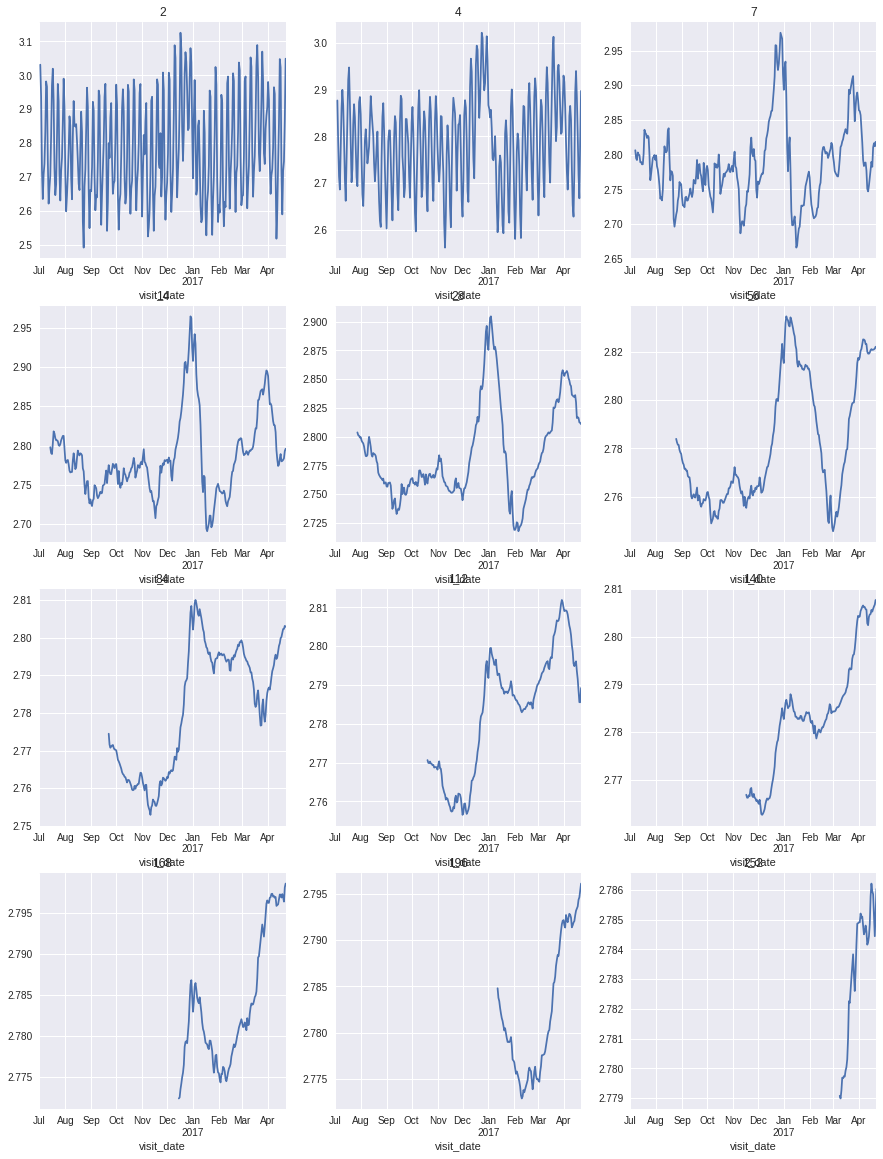

In [375]:

plt.figure(figsize=(15,20))
for i,window in enumerate([2,4,7,14,28,56,84,112,140,168,196,252]):
    plt.subplot(4,3,i+1)
    sample.rolling(window).mean().plot()
    plt.title('%d'%window)
    #plt.show()
    #.diff(periods=1)

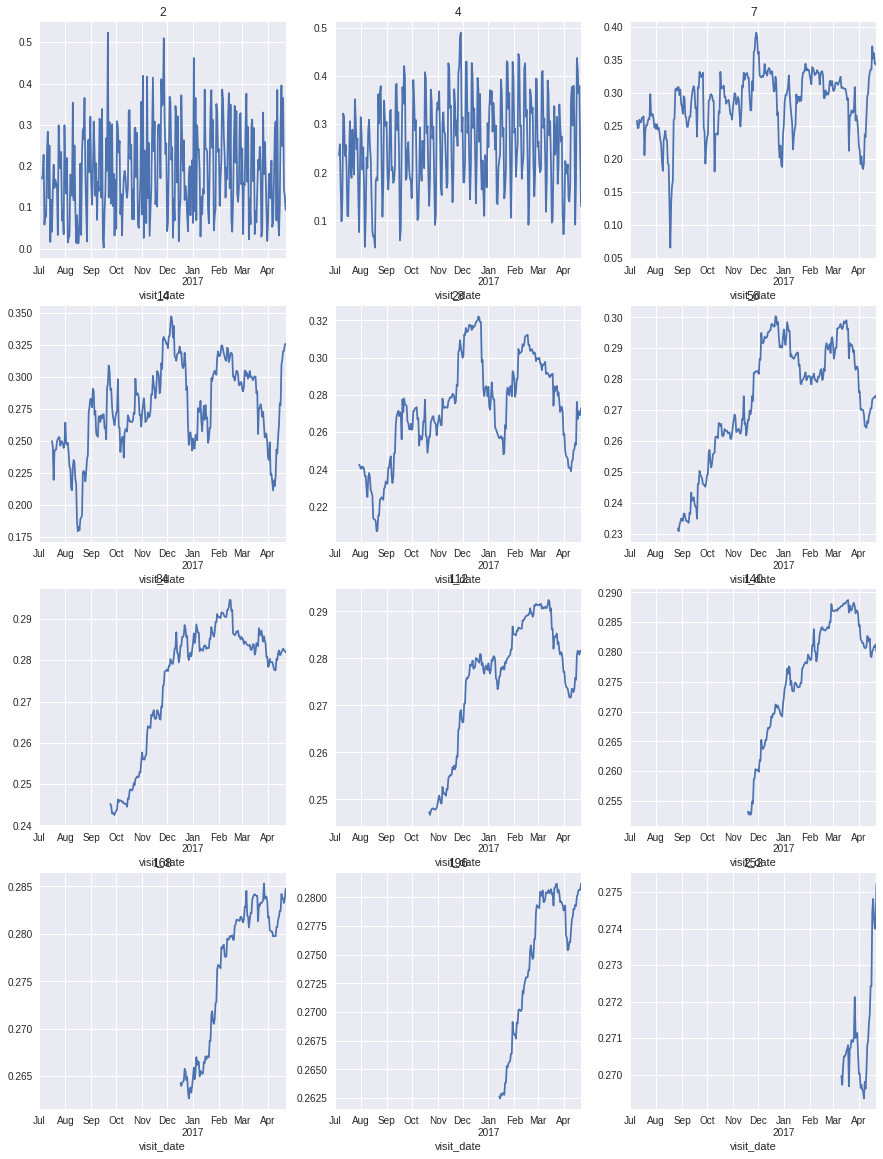

In [369]:
plt.figure(figsize=(15,20))
for i,window in enumerate([2,4,7,14,28,56,84,112,140,168,196,252]):
    plt.subplot(4,3,i+1)
    sample.diff(periods=2).rolling(window).std().plot()
    plt.title('%d'%window)
    #plt.show()

In [ ]:

daily_data=df_air_visit_data.groupby('air_store_id')['visit_date'].min()
open_date=open_date[open_date>=datetime(2016,7,1)]
sample=df_air_visit_data.join(open_date,on='air_store_id',rsuffix='_first')
sample=sample[sample['visit_date_first'].notnull()]
sample=sample.groupby('visit_date')['visitors'].agg(lambda x: np.log(1+x).mean())



for name,group in 

model = ARIMA(ts_log_ewma_diff, order=(4, 0, 0))  
                results_ARIMA = model.fit(disp=0) 

/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=2,min_periods=0,adjust=True,ignore_na=False).mean()
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=4,min_periods=0,adjust=True,ignore_na=False).mean()
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=7,min_periods=0,adjust=True,ignore_na=False).mean()
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace wit

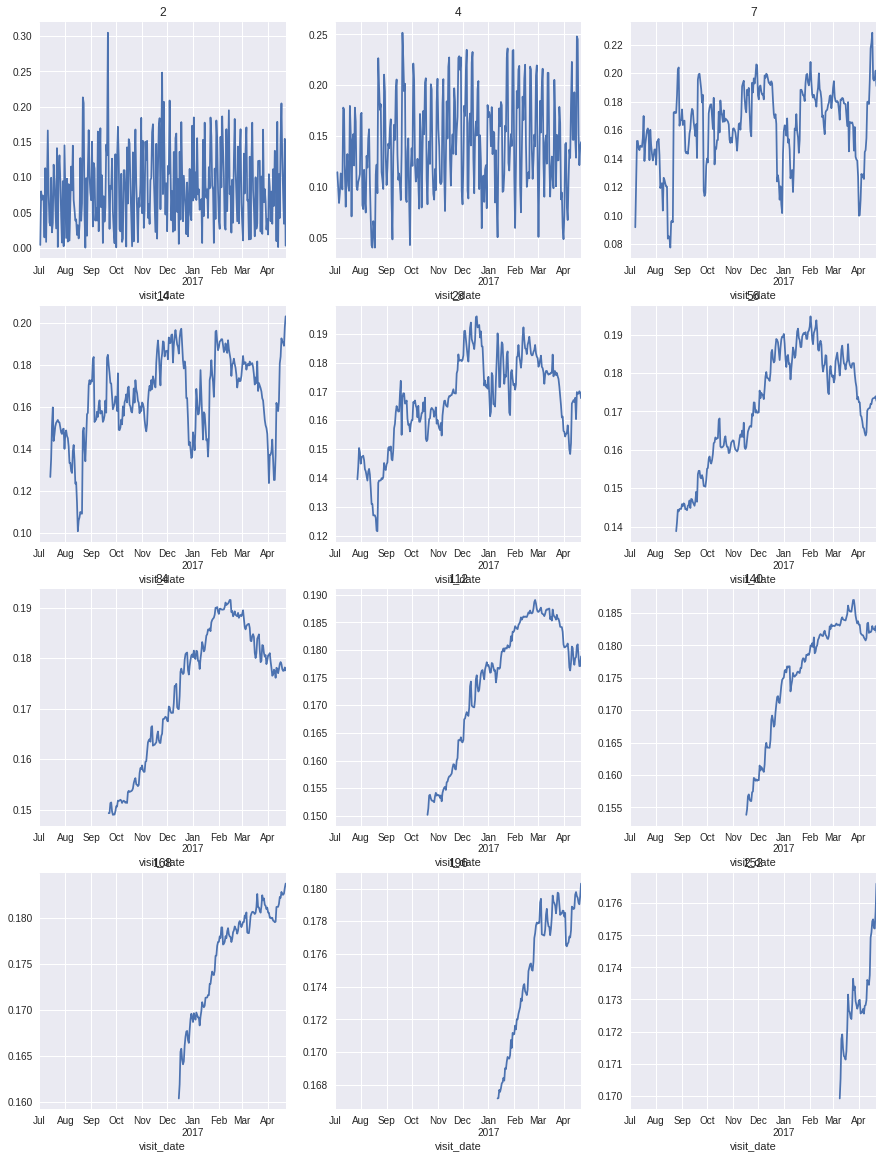

In [374]:
plt.figure(figsize=(15,20))
for i,window in enumerate([2,4,7,14,28,56,84,112,140,168,196,252]):
    plt.subplot(4,3,i+1)
    (sample-pd.ewma(sample,halflife=window)).rolling(window).std().plot()
    plt.title('%d'%window)
    #plt.show().diff(periods=1)